# Building quadrisyll compounds from the Tencent-2M (small) embedding

In [1]:
import sys
sys.path.append("../src")
import os
import re
import json
import gzip
import tarfile
from itertools import islice
from collections import Counter
import numpy as np
from tqdm.auto import tqdm
from opencc import OpenCC
import svgling
from stanza.server import CoreNLPClient
from stanford_utils import *

In [2]:
os.environ["CORENLP_HOME"] = os.path.expanduser("~/etc/stanford-corenlp-4.4.0")

In [3]:
fin = gzip.open("/mnt/md0/seantyh/parsec/tencent-ailab-embedding-zh-d200-v0.2.0-s.tar.gz", "r")
tar = tarfile.open(fileobj=fin)
_ = tar.next()
txt_tzinfo = tar.next()

In [4]:
txt_tzinfo.name

'tencent-ailab-embedding-zh-d200-v0.2.0-s/tencent-ailab-embedding-zh-d200-v0.2.0-s.txt'

In [5]:
txt_fobj = tar.extractfile(txt_tzinfo)
nvocab, hdim = [int(x) for x in txt_fobj.readline().decode().split(" ")]
nvocab, hdim

(2000000, 200)

## Extract vocabulary

In [6]:
chpat = re.compile("^[\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff]+$")
pbar = tqdm(total=nvocab)
monosylls = []
bisylls = []
quads = []
embs = []
fout = open("../data/tencent_vocabs_small.txt", "w")

while True:
    pbar.update(1)
    try:
        ln = txt_fobj.readline()
        if not ln:
            break
        toks = ln.decode().strip().split()  
        # hvec = np.array([float(x) for x in toks[1:]])
        word = toks[0]
        if not chpat.match(word):
            continue
        fout.write(word+"\n")
        if len(word)==1:
            monosylls.append(word)
        elif len(word)==2:
            bisylls.append(word)
        elif len(word)==4:
            quads.append(word)        
    except Exception as ex:
        print(ex)
fout.close()
txt_fobj.close()

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [7]:
len(quads), len(bisylls), len(monosylls)

(649697, 325585, 10818)

In [8]:
selected_quads = set()
bisylls_set = set(bisylls)

for quad_x in tqdm(quads):
    c1, c2 = quad_x[:2], quad_x[2:]
    if (c1 in bisylls_set and 
        c2 in bisylls_set):        
        selected_quads.add(quad_x)
print("Quads' bisylls constituents are also in vocab", len(selected_quads))

  0%|          | 0/649697 [00:00<?, ?it/s]

Quads' bisylls constituents are also in vocab 607402


In [9]:
print(" ".join(islice(selected_quads, 10, 20)))

得罪小人 魔法屏障 光学遥感 航运管理 贫血患者 农业知识 再三追问 粮食种子 募集方式 家电消费


## Parsing a quadrisyllabic word

2022-07-06 06:00:11 INFO: Using CoreNLP default properties for: chinese.  Make sure to have chinese models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2022-07-06 06:00:11 INFO: Starting server with command: java -Xmx6G -cp /home/seantyh/etc/stanford-corenlp-4.4.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties chinese -annotators tokenize,ssplit,pos,parse -preload -outputFormat serialized


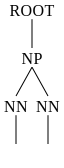

In [10]:
t2s = OpenCC('t2s.json')
text = t2s.convert("地理实体")
with CoreNLPClient(properties="chinese",
        annotators=['tokenize','ssplit','pos','parse'],
        timeout=30000,
        memory='6G', be_quiet=True) as client:
    ann = client.annotate(text)
svgling.draw_tree(to_linear(ann.sentence[0].parseTree))

In [11]:
qs_iter = iter(selected_quads)
batch_size = 20
batch_iter = iter(lambda: list(islice(qs_iter, batch_size)), [])

np_compounds = []
with CoreNLPClient(properties="chinese",
        annotators=['tokenize','ssplit','pos','parse'],
        timeout=30000,        
        memory='6G', be_quiet=True) as client:    
    for qs_list in tqdm(batch_iter):
        qs_sen = "。".join(x.strip() for x in qs_list)
        ann = client.annotate(t2s.convert(qs_sen))
        for qs_x, sent_x in zip(qs_list, ann.sentence):
            np_nodes = get_nodes(sent_x.parseTree, is_two_bisyll_np)            
            if np_nodes:
                npcs = flatten_compound(np_nodes[0])
                npcs = ((qs_x[:2], qs_x[2:]), npcs[1])
                np_compounds.append(npcs)        

2022-07-06 06:00:20 INFO: Using CoreNLP default properties for: chinese.  Make sure to have chinese models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2022-07-06 06:00:20 INFO: Starting server with command: java -Xmx6G -cp /home/seantyh/etc/stanford-corenlp-4.4.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties chinese -annotators tokenize,ssplit,pos,parse -preload -outputFormat serialized


0it [00:00, ?it/s]

### Write NPs into files

In [12]:
compound_path = "../data/tencent_vocab_nps_small.txt"
with open(compound_path, "w", encoding="UTF-8") as fout:
    for np_x in np_compounds:
        nn_x = np_x[0]
        fout.write("{},{},{}\n".format(''.join(nn_x), nn_x[0], nn_x[1]))

In [13]:
nn_path = "../data/tencent_vocab_nn_compounds_small.txt"
nn_compounds = []
with open(nn_path, "w", encoding="UTF-8") as fout:
    for np_x in np_compounds:        
        nn_x = np_x[0]
        pos_x = np_x[1]
        if any(x!="NN" for x in pos_x) or \
           any(len(w)!=2 for w in nn_x):
            continue
        fout.write("{},{},{}\n".format(''.join(nn_x), nn_x[0], nn_x[1]))
        nn_compounds.append(nn_x)

In [14]:
len(nn_compounds)

192882

In [15]:
print([''.join(x) for x in nn_compounds[:5]])

['旅客需求', '巡逻时间', '魔法屏障', '光学遥感', '航运管理']


## Collect words to include in output embeddings

In [16]:
selected = set()
bisylls_set = set(bisylls)
filtered = []

for nn_x in tqdm(nn_compounds):
    c1, c2 = nn_x
    if (c1 in bisylls_set and 
        c2 in bisylls_set):        
        selected.update((c1, c2, ''.join(nn_x)))
    else:
        filtered.append(''.join(nn_x))
selected.update(monosylls)
print("selected words", len(selected))

  0%|          | 0/192882 [00:00<?, ?it/s]

selected words 231601


In [17]:
## this should be an empty list
len(filtered)

0

In [18]:
from itertools import groupby
{gk: len(list(gv)) 
 for gk, gv 
 in groupby(sorted(selected, key=len), key=len)}

{1: 10818, 2: 27901, 4: 192882}

## Subsetting the original embedding file

In [19]:
txt_fobj = tar.extractfile(txt_tzinfo)
nvocab, hdim = [int(x) for x in txt_fobj.readline().decode().split(" ")]
nvocab, hdim
out_nvocab = len(selected)
sub_emb_path = "../data/tencent_nn_embeddings-s.txt.gz"
fout = gzip.open(sub_emb_path, "wb")
fout.write(f"{out_nvocab} {hdim}\n".encode())
pbar = tqdm(total=nvocab)
fout_lines = 1
out_buffer = selected.copy()

while True:
    pbar.update(1)
    try:
        ln = txt_fobj.readline()
        if not ln:
            break
        ln = ln.decode()
        toks = ln.strip().split()  
        # hvec = np.array([float(x) for x in toks[1:]])
        word = toks[0]
        if word in selected:
            out_buffer.remove(word)
            fout_lines += 1
            fout.write(ln.encode())        
    except Exception as ex:
        print(ex)
pbar.close()
fout.close()
txt_fobj.close()
print(fout_lines, " written (include header)")

  0%|          | 0/2000000 [00:00<?, ?it/s]

231602  written (include header)


In [20]:
## check whether there is any word left in the `selected`
## `out_buffer` should be an empty set
out_buffer

set()

## Test embedding file

In [21]:
from gensim.models import KeyedVectors

In [22]:
kv = KeyedVectors.load_word2vec_format(sub_emb_path)

In [23]:
len(kv.index_to_key)

231601

In [24]:
kv.most_similar("中文字幕", topn=3)

[('英文字幕', 0.8481001853942871),
 ('字幕', 0.84283846616745),
 ('日语字幕', 0.8051227331161499)]

In [25]:
kv.most_similar("中文", topn=3)

[('英文', 0.9023275971412659),
 ('日文', 0.851484477519989),
 ('韩文', 0.8410767912864685)]

In [26]:
kv.most_similar("字", topn=3)

[('偏旁', 0.7554795145988464),
 ('汉字', 0.7427154183387756),
 ('繁体', 0.7201398611068726)]

## Output hashes
```
../data/tencent_vocab_nps_small.txt 8662a8
../data/tencent_vocab_nn_compounds_small.txt a29857
../data/tencent_nn_embeddings-s.txt.gz b237d2
```

In [27]:
import hashlib
from pathlib import Path
for path_x in (compound_path, nn_path, sub_emb_path):
    h = hashlib.sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/tencent_vocab_nps_small.txt 8662a8
../data/tencent_vocab_nn_compounds_small.txt a29857
../data/tencent_nn_embeddings-s.txt.gz b237d2
